# Sky with the Moon Up

* https://desi.lbl.gov/trac/wiki/CommissioningCommissioningPlanning/commishdata#NightSky
* https://portal.nersc.gov/project/desi/collab/nightwatch/kpno/20191112/exposures.html
* http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2019-11-12/nightsum.html

**Data**  
* /global/projecta/projectdirs/desi/spectro/redux/daily/exposures/20191112  
* /global/projecta/projectdirs/desi/spectro/redux/daily/exposures/20191112
* Exposures 27337-27396

**Data Model**  
* https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/exposures/NIGHT/EXPID/sky-CAMERA-EXPID.html

John Moustakas

In [22]:
import os
import numpy as np
import fitsio

In [23]:
import astropy.units as u
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy.io import fits

In [24]:
import desispec.io
import desimodel.io

In [162]:
import speclite

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
sns.set(context='talk', style='ticks', font_scale=1.1)
%matplotlib inline

In [28]:
topdir = os.getenv('DESI_ROOT')+'/spectro'
gfadir = '/project/projectdirs/desi/users/ameisner/GFA/reduced/v0001'

#### Load the GFA filter curve.

In [220]:
def load_gfa_filter():
    if False:
        rfilt = speclite.filters.load_filter('decam2014-r')
    else:
        filtfile = '/global/homes/a/ameisner/ci_throughput/etc/gfa_filter_transmission_DESI-1297.dat'
        filtwave, filtresp, _, _ = np.loadtxt(filtfile, unpack=True)
        filtresp[filtresp < 0] = 0
        filtresp[0] = 0
        filtresp[-1] = 0
        srt = np.argsort(filtwave)
        filtwave, filtresp = filtwave[srt] * 10, filtresp[srt]
        rfilt = speclite.filters.FilterResponse(wavelength=filtwave * u.Angstrom,
                                                response=filtresp,
                                                meta=dict(group_name='gfa', band_name='r'))
        
        return rfilt

In [221]:
rfilt = load_gfa_filter()

#### Specify the night and range of GFA and spectrograph exposure IDs.

In [29]:
night = 20191112
expid_start, expid_end = 27337, 27396
expids = np.arange(expid_end - expid_start + 1) + expid_start

#### Read A. Meisner's reductions to get the sky background in the GFAs vs moon separation.

In [166]:
def read_gfa(night, expid, raw=False):
    sexpid = '{:08d}'.format(expid)
    rawfname = topdir+'/data/{0}/{1}/gfa-{1}.fits.fz'.format(night, sexpid)
    fname = gfadir+'/{0}/{1}/gfa-{1}_ccds.fits'.format(night, sexpid)    
    if os.path.isfile(fname):
        # get the target-moon separation
        hdr = fitsio.read_header(rawfname, ext=1)
        #print(hdr)
        
        ra, dec, moonra, moondec = hdr['SKYRA'], hdr['SKYDEC'], hdr['MOONRA'], hdr['MOONDEC']
        csky = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
        cmoon = SkyCoord(ra=moonra*u.degree, dec=moondec*u.degree, frame='icrs')
        moonsep = np.array(csky.separation(cmoon).value).astype('f4') # [degree]

        #print('Reading {}'.format(fname))
        data = Table.read(fname)
        #print(data.colnames)
        
        # pack into a table
        out = Table()
        out['sky_mag_ab'] = [np.mean(data['sky_mag_ab'])]
        out['sky_mag_ab_err'] = [np.std(data['sky_mag_ab']) / np.sqrt(len(data))]
        out['moonsep'] = [moonsep]
        #out['airmass'] = [hdr['AIRMASS']]
        
        out = out[np.argsort(out['moonsep'])[::-1]]
        
        return out
    else:
        return None

In [167]:
#data = read_gfa(night, 27390)
#data

In [168]:
def gfa_sky(night):
    out = []
    for expid in expids:
        dd = read_gfa(night, expid)
        if dd is not None:
            out.append(dd)
    return vstack(out)

Read Aaron's updated GFA analysis outputs.

In [169]:
def gfa_sky_updated():
    cat = Table(fitsio.read(os.getenv('DESI_ROOT')+'/users/ameisner/GFA/files/skymags-prelim.fits', 
                            lower=True))
    cat = cat[(cat['expid'] >= expid_start) * (cat['expid'] <= expid_end)]

    ra, dec, moonra, moondec = cat['skyra'], cat['skydec'], cat['ra_moon_deg'], cat['dec_moon_deg']
    csky = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    cmoon = SkyCoord(ra=moonra*u.degree, dec=moondec*u.degree, frame='icrs')
    moonsep = np.array(csky.separation(cmoon).value) # [degree]
    
    out = Table()
    out['camera'] = cat['extname']
    out['ra'] = cat['skyra']
    out['dec'] = cat['skydec']
    out['sky_mag_ab'] = cat['skymag_median_top_camera'].astype('f4')
    #out['sky_mag_ab_err'] = [np.std(data['sky_mag_ab']) / np.sqrt(len(data))]
    out['moonsep'] = moonsep.astype('f4')
    
    out = out[np.argsort(out['moonsep'])[::-1]]
    
    return out    

In [170]:
if False:
    gfa = gfa_sky(night)
else:
    gfa = gfa_sky_updated()
gfa

camera,ra,dec,sky_mag_ab,moonsep
bytes6,float64,float64,float32,float32
GUIDE5,9.496729,25.49872,18.603962,45.05746
GUIDE2,9.496729,25.49872,18.578222,45.05746
GUIDE2,9.496779,25.49873,18.578348,45.049534
GUIDE5,9.496779,25.49873,18.609594,45.049534
GUIDE2,9.496829986572266,25.498741,18.590765,45.04158
GUIDE5,9.496829986572266,25.498741,18.610603,45.04158
GUIDE2,9.496879577636719,25.498751,18.585062,45.033653
GUIDE5,9.496879577636719,25.498751,18.610685,45.033653
GUIDE2,9.496958,25.49876,18.590044,45.025208


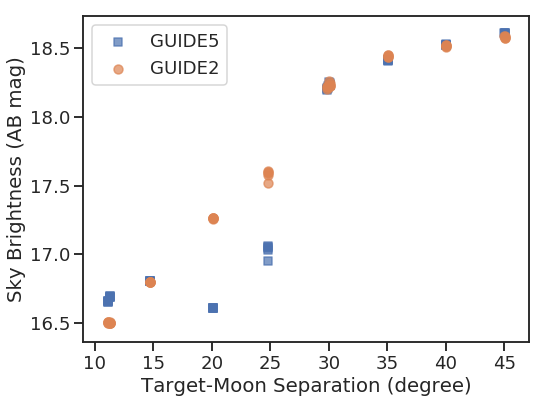

In [171]:
fig, ax = plt.subplots(figsize=(8, 6))
for cam, mark in zip(set(gfa['camera']), ('s', 'o')):
    ww = gfa['camera'] == cam
    ax.scatter(gfa['moonsep'][ww], gfa['sky_mag_ab'][ww], 
               label=cam, marker=mark, s=80, alpha=0.7)
    #ax.invert_yaxis()
    #ax.set_ylim(17.5, 14.5)
    ax.set_xlabel('Target-Moon Separation (degree)')
    ax.set_ylabel('Sky Brightness (AB mag)')
ax.legend()

#### Read the spectroscopic reductions to get the sky spectra vs moon separation.

In [172]:
def read_spec(night, expid):
    sexpid = '{:08d}'.format(expid)
    datadir = topdir+'/redux/daily/exposures/{}/{}/'.format(night, sexpid)
    if os.path.isdir(datadir):
        #fr = desispec.io.read_frame('{}/frame-r3-{}.fits'.format(datadir, sexpid))
        sp = desispec.io.read_frame('{}/sframe-r3-{}.fits'.format(datadir, sexpid))
        sky = desispec.io.read_sky('{}/sky-r3-{}.fits'.format(datadir, sexpid))
        return sp, sky
        #return fr, sp, sky
    else:
        return None, None    

In [173]:
sp, sky = read_spec(night, 27339)

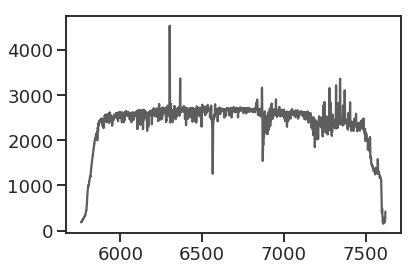

In [174]:
keep = np.where(sp.fibermap['OBJTYPE'] == 'SKY')[0]
medsky = np.percentile(sky.flux[keep, :], axis=0, q=50)
q25sky = np.percentile(sky.flux[keep, :], axis=0, q=25)
q75sky = np.percentile(sky.flux[keep, :], axis=0, q=75)
#plt.fill_between(sky.wave, q25sky, q75sky)
rand = np.random.RandomState(seed=1)
these = rand.choice(keep, size=20, replace=False)
#[plt.plot(sky.wave, sky.flux[ii, :], alpha=1.0) for ii in these]
plt.plot(sky.wave, medsky, alpha=0.7, color='k')

In [245]:
def spec_sky():
    _rfilt = speclite.filters.FilterSequence([rfilt])
    rand = np.random.RandomState(seed=1)
    moonsep, meansky, stdsky = [], [], []
    specsky, specwave = [], []
    for expid in expids:
        sp, sky = read_spec(night, expid)
        if sky is not None:
            # hack for getting the object-moon separation!!
            moonsep.append(sky.header['PROGRAM'][:3])
            
            # convolve the spectrum with the r-band filter curve
            keep = sp.fibermap['OBJTYPE'] == 'SKY'
            padflux, padwave = _rfilt.pad_spectrum(sky.flux[keep, :], sky.wave, method='edge')
            abmags = _rfilt.get_ab_magnitudes(padflux, padwave)[rfilt.name]
            
            meansky.append(np.mean(abmags))
            stdsky.append(np.std(abmags) / np.sqrt(len(abmags)))
            
            # get the median spectra for this moon separation
            specwave.append(sky.wave)
            specsky.append(np.percentile(sky.flux[keep, :], axis=0, q=50))
            #q25sky = np.percentile(sky.flux[keep, :], axis=0, q=25)
            #q75sky = np.percentile(sky.flux[keep, :], axis=0, q=75)
            #these = rand.choice(keep, size=20, replace=False)
            #[plt.plot(sky.wave, sky.flux[ii, :], alpha=1.0) for ii in these]
            #plt.plot(sky.wave, medsky, alpha=0.7, color='k')            
            
    out = Table()
    out['moonsep'] = np.hstack(moonsep).astype('f4')
    out['meansky'] = np.hstack(meansky).astype('f4')
    out['stdsky'] = np.hstack(stdsky).astype('f4')
    out['specwave'] = specwave
    out['specsky'] = specsky
    
    out = out[np.argsort(out['moonsep'])[::-1]]
    
    return out

In [246]:
spec = spec_sky()
spec

moonsep,meansky,stdsky,specwave [2326],specsky [2326]
float32,float32,float32,float64,float64
45.0,-28.053133,9.788499e-06,5760.0 .. 7620.0,35.20424270629883 .. 69.00575256347656
40.0,-28.140474,1.0165507e-05,5760.0 .. 7620.0,38.95997619628906 .. 72.70320510864258
35.0,-28.265951,8.842264e-06,5760.0 .. 7620.0,41.19006156921387 .. 81.04788589477539
30.0,-28.42732,8.333034e-06,5760.0 .. 7620.0,52.36232376098633 .. 88.49101257324219
30.0,-28.440067,9.4806055e-06,5760.0 .. 7620.0,51.56990432739258 .. 91.60662460327148
25.0,-29.099781,9.152934e-06,5760.0 .. 7620.0,86.75776290893555 .. 186.1117935180664
20.0,-29.358303,7.0438914e-06,5760.0 .. 7620.0,107.38399505615234 .. 235.17302703857422
15.0,-29.651146,8.676515e-06,5760.0 .. 7620.0,143.58824157714844 .. 316.5589599609375
11.0,-29.887804,7.5874077e-06,5760.0 .. 7620.0,178.16889190673828 .. 396.22503662109375


In [247]:
#rfilt.wavelength

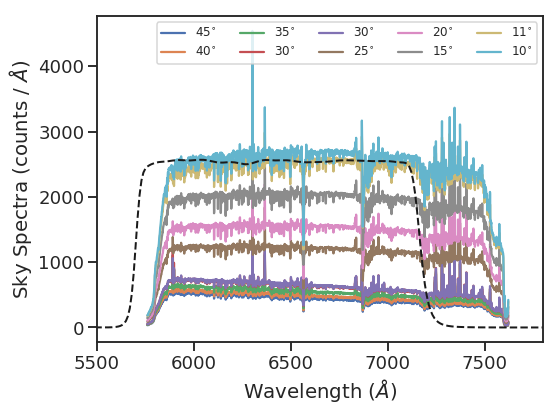

In [248]:
fig, ax = plt.subplots(figsize=(8, 6))

ref = spec['moonsep'].argmax()
#print(ref, spec['specsky'][ref])
for ss in spec:
    #print(ss['specwave'], ss['specsky'] / spec['specsky'][ref])
    ax.plot(ss['specwave'], ss['specsky'],# / spec['specsky'][0],
            label=r'{:.0f}$^{{\circ}}$'.format(ss['moonsep']))
ax.plot(rfilt.wavelength, rfilt.response / np.max(rfilt.response) * np.median(spec['specsky'][-1]),
        color='k', ls='--', lw=2)

ax.set_xlim(5500, 7800)
#ax.set_yscale('log')
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Sky Spectra (counts / $\AA$)')
ax.legend(ncol=5, fontsize=12)
#ax.set_title('Night {}'.format(night))

Text(0.5,1,'Night 20191112')

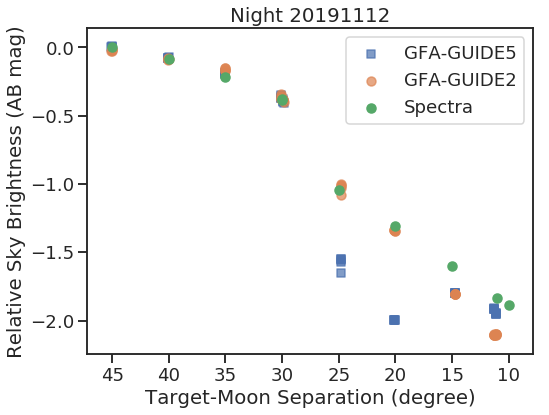

In [249]:
fig, ax = plt.subplots(figsize=(8, 6))

specref = spec['meansky'][spec['moonsep'].argmax()]

for cam, mark in zip(set(gfa['camera']), ('s', 'o')):
    ww = gfa['camera'] == cam
    gfaref = gfa['sky_mag_ab'][gfa['moonsep'].argmax()]
    ax.scatter(gfa['moonsep'][ww], gfa['sky_mag_ab'][ww] - gfaref, 
               label='GFA-{}'.format(cam), marker=mark, s=80, alpha=0.7)
               
#ax.scatter(gfa['moonsep'], gfa['sky_mag_ab'] - gfaref, label='GFAs')
ax.scatter(spec['moonsep'], spec['meansky'] - specref, label='Spectra')
ax.invert_xaxis()
#ax.set_ylim(17.5, 14.5)
ax.set_xlabel('Target-Moon Separation (degree)')
ax.set_ylabel('Relative Sky Brightness (AB mag)')
ax.legend()
ax.set_title('Night {}'.format(night))